# Gender Classification

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, GlobalMaxPooling2D, Dense, Dropout
import matplotlib.pyplot as plt
import h5py

## Parameter Setup

In [2]:
BATCH_SIZE = 64
EPOCHS = 100
NUM_FOLDS = 5

model = str(input('socofing / family : '))
type = str(input('raw / default / high / low : '))

if model == 'socofing':
    if type == 'raw':
        m_path = r'C:\Skripsi\GenderClassification\datasets\socofing\raw\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\socofing\raw\F'
        IMG_SIZE = (90, 97)
        IMG_SHAPE = (90, 97, 1)
        model_name = 'socofing-raw'
        model_save_path = r'C:\Skripsi\GenderClassification\res\socofing\raw'
    elif type == 'default':
        m_path = r'C:\Skripsi\GenderClassification\datasets\socofing\gabor\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\socofing\gabor\F'
        IMG_SIZE = (270, 291)
        IMG_SHAPE = (270, 291, 1)
        model_name = 'socofing-def'
        model_save_path = r'C:\Skripsi\GenderClassification\res\socofing\gabor'
    elif type == 'high':
        m_path = r'C:\Skripsi\GenderClassification\datasets\socofing\gabor-high\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\socofing\gabor-high\F'
        IMG_SIZE = (270, 291)
        IMG_SHAPE = (270, 291, 1)
        model_name = 'socofing-hi'
        model_save_path = r'C:\Skripsi\GenderClassification\res\socofing\gabor-high'
    elif type == 'low':
        m_path = r'C:\Skripsi\GenderClassification\datasets\socofing\gabor-low\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\socofing\gabor-low\F'
        IMG_SIZE = (270, 291)
        IMG_SHAPE = (270, 291, 1)
        model_name = 'socofing-lo'
        model_save_path = r'C:\Skripsi\GenderClassification\res\socofing\gabor-low'
elif model == 'family':
    if type == 'raw':
        m_path = r'C:\Skripsi\GenderClassification\datasets\family\raw\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\family\raw\F'
        IMG_SIZE = (512, 512)
        IMG_SHAPE = (512, 512, 1)
        model_name = 'family-raw'
        model_save_path = r'C:\Skripsi\GenderClassification\res\family\raw'
    elif type == 'default':
        m_path = r'C:\Skripsi\GenderClassification\datasets\family\gabor\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\family\gabor\F'
        IMG_SIZE = (256, 256)
        IMG_SHAPE = (256, 256, 1)
        model_name = 'family-def'
        model_save_path = r'C:\Skripsi\GenderClassification\res\family\gabor'
    elif type == 'high':
        m_path = r'C:\Skripsi\GenderClassification\datasets\family\gabor-high\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\family\gabor-high\F'
        IMG_SIZE = (256, 256)
        IMG_SHAPE = (256, 256, 1)
        model_name = 'family-hi'
        model_save_path = r'C:\Skripsi\GenderClassification\res\family\gabor-high'
    elif type == 'low':
        m_path = r'C:\Skripsi\GenderClassification\datasets\family\gabor-low\M'
        f_path = r'C:\Skripsi\GenderClassification\datasets\family\gabor-low\F'
        IMG_SIZE = (256, 256)
        IMG_SHAPE = (256, 256, 1)
        model_name = 'family-lo'
        model_save_path = r'C:\Skripsi\GenderClassification\res\family\gabor-low'

## Data Loading

In [3]:
def load_images_from_folder(folder, label, img_size):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img.reshape(*IMG_SHAPE) / 255.0
            images.append(img)
            labels.append(label)
    return images, labels

## CNN Model

In [4]:
def create_cnn_model(input_shape):
    model = Sequential()
    
    model.add(InputLayer(input_shape=input_shape))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.summary()
    return model

## Model Training

In [5]:
def train_model(X_train, y_train, X_val, y_val, input_shape, model_name, fold_no):

    # Model creation and compilation
    model = create_cnn_model(input_shape)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=20,
                                                     min_lr=1e-7)

    # Training the model without data augmentation
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(X_val, y_val),
                        callbacks=[reduce_lr])

    # Save the model
    model_path = os.path.join(model_save_path, f"{model_name}-fold{fold_no}.h5")
    model.save(model_path)

    # Save the history to HDF5 file
    history_file_path = os.path.join(model_save_path, f"{model_name}_history_fold{fold_no}.h5")
    with h5py.File(history_file_path, 'w') as hf:
        # Create a group to store the history data
        history_group = hf.create_group('history')

        # Store the history data as datasets within the group
        for key, value in history.history.items():
            history_group.create_dataset(key, data=value)

    return history, model

## Classification Report

In [6]:
def print_classification_report(y_true, y_pred, target_names, fold_no):
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    if report is None:
        print(f"No classification report generated for Fold {fold_no}")
        return None
    
    print(f"Classification Report for Fold {fold_no}")
    print(f"Precision (Weighted): {report['weighted avg']['precision']:.4f}")
    print(f"Recall (Weighted): {report['weighted avg']['recall']:.4f}")
    print(f"F1-Score (Weighted): {report['weighted avg']['f1-score']:.4f}")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy for Fold {fold_no}: {accuracy:.4f}")

    return report

## Plotting

In [7]:
def plot_history(histories, model_name):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    for i, history in enumerate(histories, 1):
        plt.plot(history.history['accuracy'], label=f'Training Accuracy Fold {i}', linestyle='--')
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy Fold {i}', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    for i, history in enumerate(histories, 1):
        plt.plot(history.history['loss'], label=f'Training Loss Fold {i}', linestyle='--')
        plt.plot(history.history['val_loss'], label=f'Validation Loss Fold {i}', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(model_name)
    plt.tight_layout()
    plt.show()

## Main Function

In [8]:
def main():
    male_images, male_labels = load_images_from_folder(m_path, 0, IMG_SIZE)
    female_images, female_labels = load_images_from_folder(f_path, 1, IMG_SIZE)

    X = np.array(male_images + female_images)
    y = np.array(male_labels + female_labels)

    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)
    
    histories = []
    weighted_precisions = []
    weighted_recalls = []
    weighted_f1s = []
    reports = []

    fold_no = 1
    for train, test in kfold.split(X, y):
        X_train, X_val = X[train], X[test]
        y_train, y_val = y[train], y[test]

        history, model = train_model(X_train, y_train, X_val, y_val, IMG_SHAPE, model_name, fold_no)
        histories.append(history)

        y_pred = model.predict(X_val)
        y_pred = (y_pred > 0.5).astype(int)

        report = print_classification_report(y_val, y_pred, target_names=['Male', 'Female'], fold_no=fold_no)
        reports.append(report)

        if report is not None:
            weighted_precision = report['weighted avg']['precision']
            weighted_recall = report['weighted avg']['recall']
            weighted_f1 = report['weighted avg']['f1-score']

            weighted_precisions.append(weighted_precision)
            weighted_recalls.append(weighted_recall)
            weighted_f1s.append(weighted_f1)
        
        fold_no += 1

    plot_history(histories, model_name)

    mean_weighted_precision = np.mean(weighted_precisions)
    mean_weighted_recall = np.mean(weighted_recalls)
    mean_weighted_f1 = np.mean(weighted_f1s)

    print(f"Mean Weighted Precision: {mean_weighted_precision:.4f}")
    print(f"Mean Weighted Recall: {mean_weighted_recall:.4f}")
    print(f"Mean Weighted F1-Score: {mean_weighted_f1:.4f}")

    # Save classification report to a text file
    report_file_path = os.path.join(model_save_path, f"{model_name}_classification_report.txt")
    with open(report_file_path, 'w') as file:
        for fold_no, report in enumerate(reports, 1):
            file.write(f"Classification Report for Fold {fold_no}:\n")
            if report is not None:
                file.write(f"Precision (Weighted): {report['weighted avg']['precision']:.4f}\n")
                file.write(f"Recall (Weighted): {report['weighted avg']['recall']:.4f}\n")
                file.write(f"F1-Score (Weighted): {report['weighted avg']['f1-score']:.4f}\n")
            else:
                file.write("No classification report generated.\n")
            file.write("\n")
        file.write(f"Mean Weighted Precision: {mean_weighted_precision:.4f}\n")
        file.write(f"Mean Weighted Recall: {mean_weighted_recall:.4f}\n")
        file.write(f"Mean Weighted F1-Score: {mean_weighted_f1:.4f}\n")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 88, 95, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 88, 95, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 47, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 44, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 45, 64)       2

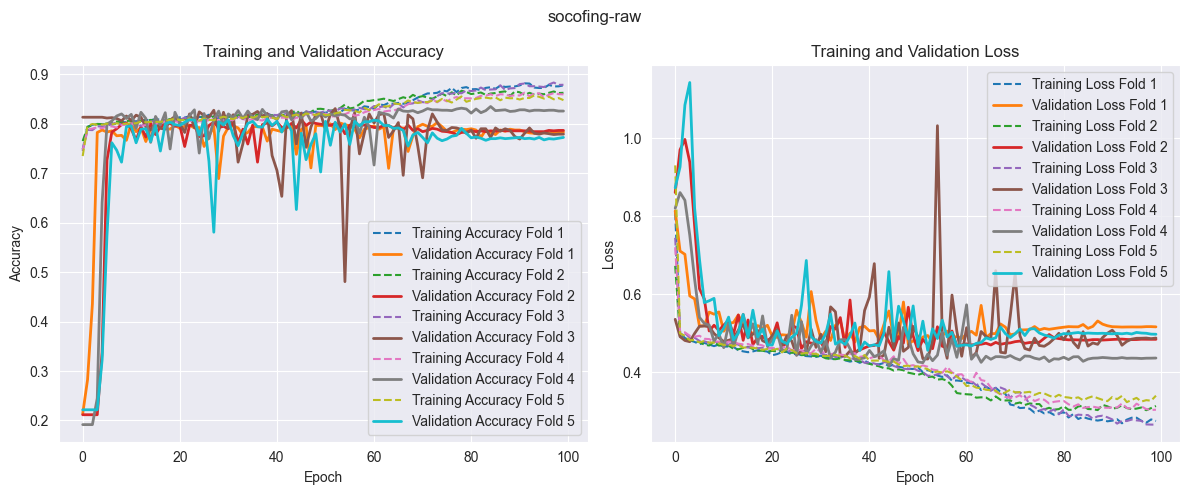

Mean Weighted Precision: 0.7731
Mean Weighted Recall: 0.7895
Mean Weighted F1-Score: 0.7774


In [9]:
if __name__ == '__main__':
    main()